# Monte Carlo Markov Chains (MCMC)

MCMC methods are algorithms that uses Markov Chains to perform Monte Carlo estimation. The major application of MCMC is to generate an array of samples coming from an unknown distribution. Throughout the process of generation, the samples _converges_. However, the convergence in this case does not mean the values converge into a single point, but rather they converge to a distribution of possible points. 

In this exercise 3 popular sampling methods will be used to sample from bivariate gaussian distribution. MCMC will be also used to sample from complex distribution and to make an educated guess about the _posteriori_ distribution. 

## Sampling from a bivariate Gaussian

MCMC will be used to draw samples from bivariate gaussian distribution. Obviously, the method applied here is not the best one for sampling from gaussian. Instead, the goal is to implement sampling methods. 


In [14]:
import itertools
import math
import random
import time
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats
import theano.tensor as T

In [2]:
def plot_samples(
    samples1: np.ndarray, 
    samples2: Optional[np.ndarray] = None,
    mean: Optional[Tuple[float, float]] = None,
) -> None:
    
    fig, ax = plt.subplots()
    plt.grid()
    ax.scatter(samples1[:,0], samples1[:,1], 
               marker="x", color="green", label='observed')
    if mean is not None:
        ax.scatter(*mean, marker='o', c='r', label='observed mean')
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], 
                   marker="x", color="orange", label='generated')
    plt.legend()
    plt.show()

In [3]:
class UnivariateGaussian:
    
    def __init__(self, mean: float, std: float):
        """Univariate Gaussian distribution."""
        self.mean = mean
        self.std = std
        
    def sample(self, n_samples: int = 1) -> np.ndarray:
        """Sampling from the distribution."""
        return np.random.normal(self.mean, self.std, n_samples)

The bivariate gaussian methods were implemented following video: https://www.youtube.com/watch?v=fb8uE4NM2fc

- x1_cond_x2: conditional distribution $p(x_1 | x_2)$
- x2_cond_x1: conditional distribution $p(x_2 | x_1)$

In [4]:
class BivariateGaussian:
    
    def __init__(
        self, 
        mean1: float, std1: float, 
        mean2: float, std2: float, 
        p: float,
    ):
        """Bivariate Gaussian Distribution.
        
        Parameters:
        -----------
        mean1
            Mean parameter of the first coordinate.
        sdt1
            Standard deviation parameter of the first coordinate.
        mean2
            Mean parameter of the second coordinate.
        std2
            Standard deviation parameter of the second coordinate.
        p
            The correlation coefficient.
        """
        self.mean1 = mean1
        self.std1 = std1
        self.mean2 = mean2
        self.std2 = std2
        self.p = p
        
        # Bivariate gaussian vector of means.
        self.mean: np.ndarray = np.array([self.mean1, self.mean2])
        # Bivariate gaussian covariance matrix.
        self.cov: np.ndarray = np.array([
            [self.std1 ** 2, self.p * self.std1 * self.std2],
            [self.p * self.std1 * self.std2, self.std2 ** 2],
        ])
        
        # Marginal distributions.
        self.marginal_x1 = UnivariateGaussian(
            self.mean1, self.std1)
        self.marginal_x2 = UnivariateGaussian(
            self.mean2, self.std2)
        
    def sample(self, n_samples: int = 1) -> np.ndarray:
        return np.random.multivariate_normal(
            self.mean, self.cov, n_samples)
    
    def pdf(self, x: np.ndarray) -> Union[np.ndarray, float]:
        return scipy.stats.multivariate_normal.pdf(
            x, mean=self.mean, cov=self.cov)
        
    def x1_cond_x2(self, x2: float) -> UnivariateGaussian:
        mean = self.mean1 + (
            self.p * self.std1 * (x2 - self.mean2)
        ) / self.std2
        std = (1 - self.p**2) * self.std1**2

        return UnivariateGaussian(mean, std)

    def x2_cond_x1(self, x1: float) -> UnivariateGaussian:
        mean = self.mean2 + (
            self.p * self.std2 * (x1 - self.mean1)
        ) / self.std1
        std = (1 - self.p**2) * self.std2**2

        return UnivariateGaussian(mean, std)

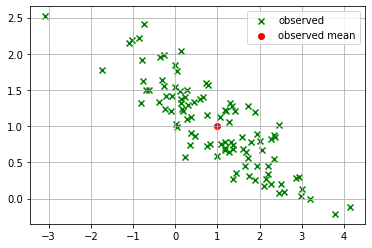

In [5]:
mean1, std1 = 1, 1.5
mean2, std2 = 1, 0.7
corr = -0.9

bivariate_gaussian = BivariateGaussian(mean1, std1, mean2, std2, corr)

plot_samples(bivariate_gaussian.sample(100), mean=(mean1,mean2))

### Ancestral sampling

The first sampling method samples from $p(x_1, x_2)$ as follows:

1. sample $x_1$: $x_1 \sim p(x_1)$
2. sample $x_2$: $x_2 \sim p(x_2 | x_1)$

In [6]:
def ancestral_sampling(n_samples: int) -> np.ndarray:
    x1 = np.empty((n_samples, ))
    x2 = np.empty((n_samples, ))

    # First step, sample from univariate gaussian.
    x1[:] = bivariate_gaussian.marginal_x1.sample(n_samples)
    for i in range(n_samples):
        # For each value from x1 sample x2 from conditional distribution.
        x2[i] = bivariate_gaussian.x2_cond_x1(x1[i]).sample(1)

    samples = np.stack([x1, x2], axis=1)
    
    return samples

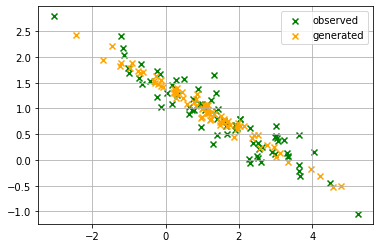

In [7]:
n_samples = 75

plot_samples(
    bivariate_gaussian.sample(n_samples), 
    ancestral_sampling(n_samples),
)

### Gibbs sampling

The algorithm for Gibbs sampling is relatively simple as well. It requires to set initial value $x^{(0)} = (x_1^{(0)}, x_2^{(0)})$. To generate $N$ samples the we simply repeat for each $i$ in $1, 2, 3, ..., N$:
1. sample $x_1^{(i)} \sim p(x_1^{(i)} | x_2^{(i-1)}) $
2. sample $x_2^{(i)} \sim p(x_2^{(i)} | x_1^{(i)})$

In addition, burning and skipping samples was added.

In [8]:
def gibbs_sampling(
    n_samples: int, burning: int = 0, skip: int = 0,
) -> np.ndarray:
    
    # Initialize x.
    point = np.zeros(2)
    
    samples = np.empty((n_samples, 2))
    n_sampled = 0
    
    for i in itertools.count(start=0):
        # Sample p(x1^(i) | x2^(i-1))
        point[0] = bivariate_gaussian.x1_cond_x2(point[1]).sample(1)
        # Sample p(x2^(i) | x1^(i))
        point[1] = bivariate_gaussian.x2_cond_x1(point[0]).sample(1)
        
        # Samples burning and skipping.
        if i >= burning and (i - burning) % (skip + 1) == 0:
            samples[n_sampled] = point
            n_sampled += 1
            
            if n_sampled == n_samples:
                break

    return samples

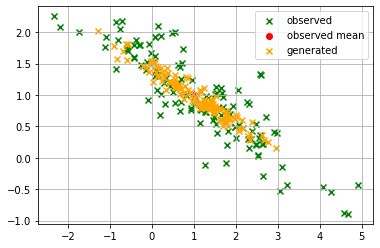

In [9]:
n_samples = 125
burning = 200
skip = 75

plot_samples(
    bivariate_gaussian.sample(n_samples), 
    gibbs_sampling(n_samples, burning=burning, skip=skip),
    mean=(mean1, mean2),
)

### Metropolis–Hastings sampling

Metropolis–Hastings requires arbitrary initial point $x^{(0)}$ and distribution $Q$ that will be used for sampling candidates. Here, $Q$ is going to be a bivariate gaussian distribution with mean vector equal to previous point and starndard deviation of the value provided as the function parameter. The algorithm generates a candidate from distribution $Q$ and later compares its PDF to compute a ratio that is compared against a random number. Hence, the algorithm accepts or rejects candidates. It is worth to check on acceptance ratio since its low value may give evidence for wrong parameter values and poor sampling performance.

The sampling can be summarized in the following steps:
1. Initialize $x_t=x^{(0)}, Q$.
2. Generate candidate $x_c \sim Q(.|x_t)$.
3. Calculate acceptance ratio $a = f(x_c)/f(x_t)$. $f$ proportional to the target density function.
4. Generate random variable $u \sim U(0,1)$, if $a \le u$ accept and set $x_t=x_c$ otherwise reject.

In [10]:
def metropolis_sampling(
    n_samples: int, noise_std: float = 1.,
    burning: int = 0, skip: int = 0
) -> np.ndarray:
    
    point = np.zeros(2)
    samples = np.empty((n_samples, 2))
    
    n_sampled = 0
    accepted = 0
    rejected = 0
    for i in itertools.count(start=0):
        # Sampling a candidate.
        candidate = BivariateGaussian(
            mean1=point[0], std1=noise_std,
            mean2=point[1], std2=noise_std, p=0
        ).sample(1)[0]
        
        # Acceptance ratio.
        a = min(
            1, 
            bivariate_gaussian.pdf(candidate) / bivariate_gaussian.pdf(point),
        )
        u = np.random.uniform()
        # Accept or reject.
        if u < a:
            point = candidate
            accepted += 1
        else:
            rejected += 1
            
        # Samples burning and skipping.
        if i >= burning and (i - burning) % (skip + 1) == 0:
            samples[n_sampled] = candidate
            n_sampled += 1
            if n_sampled == n_samples:
                break

    print("Acceptance rate: ", accepted / (accepted + rejected))
    return samples

Acceptance rate:  0.7648041775456919


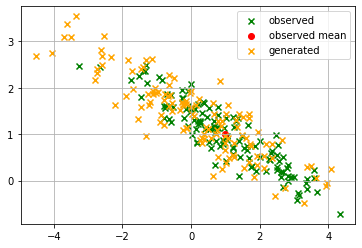

In [11]:
n_samples = 125
burning = 150
skip = 75
noise_std = .2

plot_samples(
    bivariate_gaussian.sample(n_samples),
    metropolis_sampling(n_samples, noise_std, 
                        burning=burning, skip=skip),
    mean=(mean1, mean2),
)

## Example application

**This example was based on the Chapter 3 from the book _Bayesian Methods for Hackers_
(http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)**

In this section a complex distribution will be generated from 2 gaussians. Then, MCMC will be  used to draw from the distribution and approximate the target distribution. `PyMC` will be used to focus on the application instead of technicalities.

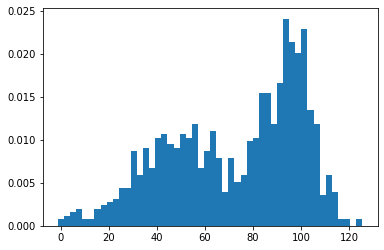

In [2]:
n_samples = 500
s1 = np.random.normal(50, 20, n_samples)
s2 = np.random.normal(95, 10, n_samples)
observed = np.concatenate((s1, s2))

plt.hist(observed, bins=50, density=True)
plt.show()

The `PyMC` model will assume existance of two normal distributions of unknown parameters. We assume we know nothing about the real distribution (even though in this case we use only simulated data). Hence, the means of the normal distributions are assumed to be somewhere between 40 and 60 for the mean $\mu_1$ of the first distribution and 90 and 110 for the mean $\mu_2$ for the second distribution, as such peaks appear on the plot. To model these variables, let's asumme they are also comming from the normal distribution. Means of these assumed distributions will be middle values of the proposed ranges and the standard deviation is the distance between middle and the proposed boundary:
- $\mu_1 \sim \mathcal{N}(50, 10)$,
- $\mu_2 \sim \mathcal{N}(100, 10)$.

Since it is hard to say anything about the standard deviations of the underlying distributions we will simply assume they are somewhere between 0 and 100 without any preference:
- $\sigma_1 \sim \mathcal{U}(0, 100)$,
- $\sigma_2 \sim \mathcal{U}(0, 100)$.

Furthermore, a probability of the data coming from one of the clusters is modeled.

In [16]:
with pm.Model() as model:
    # Probability of the data coming from the cluster.
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical(
        "assignment", p,
        shape=observed.shape[0],
        testval=np.random.randint(0, 2, observed.shape[0]),
    )
    
    # Standard deviations and means of the normal distributions.
    sigmas = pm.Uniform("sigmas", 0, 100, shape=2)
    mus = pm.Normal("means",
                    mu=np.array([50, 100]),
                    sd=np.array([10, 10]),
                    shape=2)

    # Select mean and std depending on the cluster.
    mu = pm.Deterministic('mu', mus[assignment])
    sigma = pm.Deterministic('sigma', sigmas[assignment])
    
    # Model the final variable where data comes from one of the clusters.
    observations = pm.Normal("obs", mu=mu, sd=sigma, observed=observed)

In [17]:
with model:
    # Run MCMC with Metropolis sampling.
    step1 = pm.Metropolis(vars=[p, sigmas, mus])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

/tmp/ipykernel_33186/3530109868.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2 = pm.ElemwiseCategorical(vars=[assignment])
/home/pawel/miniconda3/envs/generative-models/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sigmas]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 414 seconds.
/home/pawel/miniconda3/envs/generative-models/lib/python3.8/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


Plots below show traces of the parameters during MCMC. It can be noticed that there's quite some uncertainty about the standard deviation $\sigma_1$ as the value tends to vary a lot.

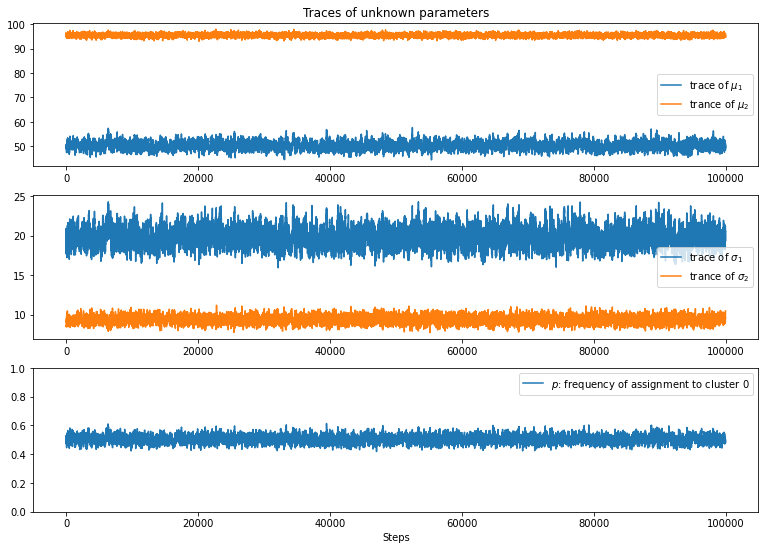

In [26]:
# Source: https://www.github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb
mu_trace = trace["means"]
std_trace = trace["sigmas"]
p_trace = trace["p"]

fig = plt.figure(figsize=(13, 9))

plt.subplot(311)
plt.plot(mu_trace, label=("trace of $\mu_1$", "trance of $\mu_2$"))
plt.title("Traces of unknown parameters")
plt.legend()

plt.subplot(312)
plt.plot(std_trace, label=("trace of $\sigma_1$", "trance of $\sigma_2$"))
plt.legend()

plt.subplot(313)
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0")
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Furhter look on the expectations about sigma parameters shows that even though the model is less certain about the $\sigma_1$ the probability mass is centered around the real value. On the other hand, there is less uncertainty about $\sigma_2$ but the probability mass appears to slightly shifted to the left. 

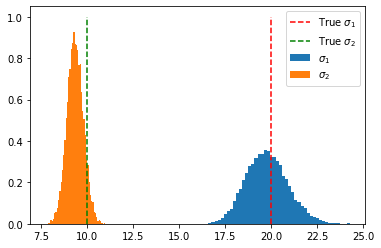

In [47]:
plt.vlines(20, 0, 1, linestyle="--", color='r', label="True $\sigma_1$")
plt.vlines(10, 0, 1, linestyle="--", color='g', label="True $\sigma_2$")
plt.hist(std_trace[:, 0], density=True, bins=50, label="$\sigma_1$")
plt.hist(std_trace[:, 1], density=True, bins=50, label="$\sigma_2$")

plt.legend()
plt.show()

Means: [50.31030692 95.46584559]
Sigmas: [19.77931866  9.37147821]


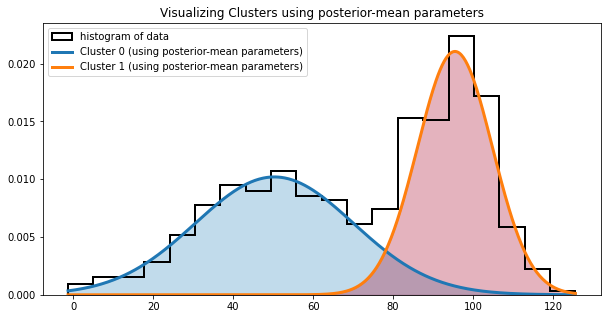

In [34]:
# Source: https://www.github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb
fig = plt.figure(figsize=(10, 5))
x = np.linspace(min(observed), max(observed), 500)

posterior_center_means = mu_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(
    observed, bins=20, histtype="step", density=True, 
    color="k", lw=2, label="histogram of data",
)

y = posterior_p_mean * scipy.stats.norm.pdf(
    x, loc=posterior_center_means[0], scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * scipy.stats.norm.pdf(
    x, loc=posterior_center_means[1], scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

print(f"Means: {posterior_center_means}\nSigmas: {posterior_std_means}")

Using MCMC, it was possible to estimate the underlying distributions basing on relatively simple assumptions. Even though the MCMC methods are used for sampling data they are also a powerful tools for Bayesian analysis. 